In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from scipy.optimize import minimize
import torch.nn.functional as F



In [38]:
class DeepRitzNet(nn.Module):
    def __init__(self,num_layers = 5, hidden_size = 50, output_size = 2, input_size = 1):
        
        super().__init__()
        h = hidden_size
        assert num_layers >=2
        self.fc = nn.ModuleList()
        self.ln = nn.ModuleList()
        self.fc.append(nn.Linear(input_size,h))
        self.ln.append(nn.LayerNorm(h))
        for _ in range(num_layers -2):
            self.fc.append(nn.Linear(h, h))
            self.ln.append(nn.LayerNorm(h))
        self.fc.append(nn.Linear(h, output_size))

    def forward(self, x):
        for i in range(len(self.fc)-1):
            # for layer in self.fc[:-1]:
            layer = self.fc[i]
            layernorm = self.ln[i]
            x = layer(x)
            x = layernorm(x)
            x = F.relu(x)**3
        x = self.fc[-1](x)
        return x

# class DeepRitzNet(nn.Module):
#     def __init__(self):
#         super(DeepRitzNet, self).__init__()
#         self.layer1 = nn.Linear(2, 20)
#         self.layer2 = nn.Linear(20, 20)
#         self.layer3 = nn.Linear(20, 20)
#         self.layer4 = nn.Linear(20, 1)

#     def forward(self, x, y):
#         xy = torch.stack((x, y), dim=2)
#         #xy = torch.flatten(xy, start_dim = 0, end_dim = 1)
#         x = torch.tanh(self.layer1(xy))
#         x = torch.tanh(self.layer2(x))
#         x = torch.tanh(self.layer3(x))
#         x = self.layer4(x)
#         return x


def energy_functional(u, x, y, g, h):
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]

    energy = 0.5 * torch.sum(u_x * u_x + u_y * u_y) - torch.sum(g * u)

    obstacle_term = (u - g)
    energy += (10 ** 3) * torch.sum(torch.square(obstacle_term))

    penalty_1 = torch.sum(torch.square(torch.max(torch.zeros_like(u), g - u)))
    energy += (10 ** 3) * penalty_1

    return torch.mean(energy)


def train(model, x, y, g, epochs=5000, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        u = model(x)

        energy = energy_functional(u, x, y, g, h)
        loss = energy  # We maximize the energy functional, equivalent to minimizing its negation
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    u_approx = model(x, y).detach().numpy()

    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, u_approx, levels=20, cmap='viridis')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Approximate Solution')
    plt.grid(True)
    plt.show()


x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

# Convert the grid points to tensors
x_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(Y, dtype=torch.float32)

# Flatten the tensors
x_flat = torch.flatten(x_tensor)
y_flat = torch.flatten(y_tensor)

g = np.sqrt(1 - np.sqrt(X ** 2 + Y ** 2) ** 2)
g[np.sqrt(X ** 2 + Y ** 2) > 1] = -1

x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
g = torch.tensor(g, dtype=torch.float32)

model = DeepRitzNet()

train(model, x, y, g)



C:\Users\Sadman\AppData\Local\Temp\ipykernel_18924\3087562648.py:101: RuntimeWarning: invalid value encountered in sqrt
  g = np.sqrt(1 - np.sqrt(X ** 2 + Y ** 2) ** 2)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x200 and 1x50)

In [9]:
def g(x, y, r_star):
    r = np.sqrt(x**2 + y**2)
    r_tmp = np.sqrt(1 - r**2)
    cond = r <= 1
    g_val = np.ones_like(r) * (-1)
    g_val[cond] = r_tmp[cond]
    return g_val


class DeepRitzNet(nn.Module):
    def __init__(self,num_layers = 5, hidden_size = 50,output_size = 1,input_size = 1):
        super().__init__()
        h = hidden_size
        assert num_layers >=2
        self.fc = nn.ModuleList()
        self.fc.append(nn.Linear(input_size,h))
        for _ in range(num_layers -2):
            self.fc.append(nn.Linear(h, h))
        self.fc.append(nn.Linear(h, output_size))

    def forward(self, x, y):
        xy = torch.stack((x, y), dim=0)
        x = xy
        for layer in self.fc[:-1]:
            x = layer(x)
            x = F.relu(x)
        x = self.fc[-1](x)
        return x

# class DeepRitzNet(nn.Module):
#     def __init__(self):
#         super(DeepRitzNet, self).__init__()
#         self.layer1 = nn.Linear(2, 20)
#         self.layer2 = nn.Linear(20, 20)
#         self.layer3 = nn.Linear(20, 20)
#         self.layer4 = nn.Linear(20, 1)

#     def forward(self, x, y):
#         xy = torch.stack((x, y), dim=1)
#         x = torch.tanh(self.layer1(xy))
#         x = torch.tanh(self.layer2(x))
#         x = torch.tanh(self.layer3(x))
#         x = self.layer4(x)
#         return x

def u_exact(x, y, r_star):
    r = np.sqrt(x**2 + y**2)
    U_exact = np.zeros_like(r)
    cond1 = r <= r_star
    cond2 = r > r_star
    r_tmp = ((-1) * (r_star**2) * np.log(r / 2)) / np.sqrt(1 - r_star**2)
    U_exact[cond1] = np.sqrt(1 - r**2)[cond1]
    U_exact[cond2] = r_tmp[cond2]
    return U_exact

def energy_functional(u_int, u_bound, x_interior, y_interior, x_boundary, y_boundary, g, f, h):
    u_x = torch.autograd.grad(u_int, x_interior, grad_outputs=torch.ones_like(u_int), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u_int, y_interior, grad_outputs=torch.ones_like(u_int), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_interior, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]

    energy = 0.5 * torch.sum(u_x * u_x + u_y * u_y) - torch.sum(f * u_int)

    obstacle_term = torch.min((u_int - g), torch.zeros_like(u_int - g))
    energy += (10 ** 0) * torch.sum(torch.square(obstacle_term))

#     interior_energy = torch.mean(torch.max(torch.zeros_like(u_xx + u_yy), -u_xx - u_yy - f))
#     energy += (10 ** 6) * interior_energy

    boundary_energy = torch.mean(torch.square(u_bound - h))
    energy += (10 ** 6) * boundary_energy

    return energy


def train(model, x_interior, y_interior, x_boundary, y_boundary, g, f, h, epochs=5000, lr=0.01):
    r_star = 0.6979651482
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        u_int = model(x_interior, y_interior)
        u_bound = model(x_boundary, y_boundary)
        print(u_int.shape, u_bound.shape)
        print(g.shape, f.shape, h.shape)
        energy = energy_functional(u_int, u_bound, x_interior, y_interior, x_boundary, y_boundary, g, f, h)
        loss = energy
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 500 == 0:
            u_boun = torch.tensor(u_exact(x_boundary.detach().numpy(), y_boundary.detach().numpy(), r_star)) - u_bound
            u_in = torch.tensor(u_exact(x_interior.detach().numpy(), y_interior.detach().numpy(), r_star)) - u_int
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}, Difference: {torch.sum(u_boun) + torch.sum(u_in)}")

    
    
#     plt.figure(figsize=(8, 6))
#     plt.contourf(x, y, u_approx, levels=20, cmap='viridis')
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.title('Approximate Solution')
#     plt.grid(True)
#     plt.show()


num_interior = 500
num_boundary = 100
r_star = 0.6979651482
x_interior = np.linspace(-2, 2, num_interior)
y_interior = np.linspace(-2, 2, num_interior)

x_interior = x_interior.reshape(num_interior, 1)
y_interior = y_interior.reshape(num_interior, 1)

theta = np.random.uniform(0, 2 * np.pi, num_boundary)
x_boundary = 2 * np.cos(theta)
y_boundary = 2 * np.sin(theta)

x_boundary = x_boundary.reshape(num_boundary, 1)
y_boundary = y_boundary.reshape(num_boundary, 1)


g_interior = np.sqrt(1 - np.sqrt(x_interior ** 2 + y_interior ** 2) ** 2)
g_interior[np.sqrt(x_interior ** 2 + y_interior ** 2) > 1] = -1

h_boundary = u_exact(x_boundary, y_boundary, r_star)

x_interior_tensor = torch.tensor(x_interior, dtype=torch.float32, requires_grad=True)
y_interior_tensor = torch.tensor(y_interior, dtype=torch.float32, requires_grad=True)
g_interior_tensor = torch.tensor(g_interior, dtype=torch.float32)

x_boundary_tensor = torch.tensor(x_boundary, dtype=torch.float32, requires_grad=True)
y_boundary_tensor = torch.tensor(y_boundary, dtype=torch.float32, requires_grad=True)
h_boundary_tensor = torch.tensor(h_boundary, dtype=torch.float32)

# x_tensor = torch.cat((x_interior_tensor,x_boundary_tensor))
# y_tensor = torch.cat((y_interior_tensor,y_boundary_tensor))
# g_tensor = torch.tensor(g(x_tensor.detach().numpy(), y_tensor.detach().numpy(), r_star))
f_tensor = torch.full_like(x_interior_tensor, 0)

model = DeepRitzNet()

train(model, x_interior_tensor, y_interior_tensor, x_boundary_tensor, y_boundary_tensor, g_interior_tensor, f_tensor, h_boundary_tensor)



C:\Users\Sadman\AppData\Local\Temp\ipykernel_16404\1508150327.py:126: RuntimeWarning: invalid value encountered in sqrt
  g_interior = np.sqrt(1 - np.sqrt(x_interior ** 2 + y_interior ** 2) ** 2)
C:\Users\Sadman\AppData\Local\Temp\ipykernel_16404\1508150327.py:53: RuntimeWarning: invalid value encountered in sqrt
  U_exact[cond1] = np.sqrt(1 - r**2)[cond1]


xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
Epoch 0/5000, Loss: 5697.748046875, Difference: 402.7591857910156
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([100, 1])
xy = torch.Size([2, 500, 1])
xy = torch.Size([2, 100, 1])
torch.Size([2, 500, 1]) torch.Size([2, 100, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.S

In [15]:
l2_norm = torch.norm(torch.tensor(u_exact(x_boundary, y_boundary, r_star))\
           - model(x_boundary_tensor, y_boundary_tensor))\
+ torch.norm(torch.tensor(u_exact(x_interior, y_interior, r_star))\
             - model(x_interior_tensor, y_interior_tensor))
l2_norm

xy = torch.Size([2, 100, 1])
xy = torch.Size([2, 500, 1])


C:\Users\Sadman\AppData\Local\Temp\ipykernel_16404\1508150327.py:53: RuntimeWarning: invalid value encountered in sqrt
  U_exact[cond1] = np.sqrt(1 - r**2)[cond1]


tensor(16.5114, dtype=torch.float64, grad_fn=<AddBackward0>)

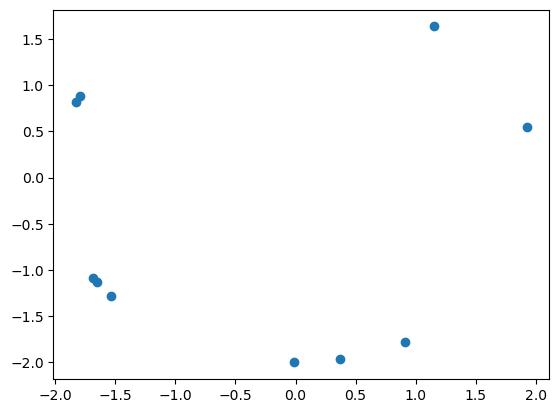

In [23]:
theta = np.random.uniform(0, 2 * np.pi, 10)
x_boundary = 2 * np.cos(theta)
y_boundary = 2 * np.sin(theta)
plt.scatter(x_boundary, y_boundary)